# Simulation and EM Maximization of the 1D Simple Likelihood for scRNA-seq

In this exercise, I generate some data that (could) look like RNA seq in 1 dimension under some assumptions, and design a likelihood function that could recover (some) parameters.

I describe an EM-like optimization algorithm to approximately maximize this objective.

### Imports

In [5]:
%matplotlib inline

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.stats.weightstats import DescrStatsW
import numpy as np
import itertools
import time

### 1D Likelihood Function

I define the log liklihood given data $x_1, x_2, x_3, x_4, ... , x_N$as follows:

$$ LL(p, \mu, \sigma ; x_1, x_2, x_3, x_4, ... , x_N) = \sum_{i=1}^{N}\log\bigg(\sum_{z=0}^{\infty} \bigg[{z\choose{x_i}}p^{x_i}(1-p)^{z-x_i}\bigg] \bigg[\frac{1}{\sqrt{2\pi\sigma^{2}}} \exp\bigg(-\frac{(z-\mu)^{2}}{2\sigma^{2}}\bigg)\bigg]\bigg) $$

### Ideal optimization problem

This likelihood function is obviously not concave (so maximizing is not a convex optimization problem), but it may be possible to design some optimization procedure for finding good parameters, given some reasonable constraints on $p$ the dropout rate and $\mu$ the mean estimated from either pseudobulks for bulk RNA-seq experiments.

The optimization problem we'd like to eventually solve is:

\begin{equation*}
\begin{aligned}
& \underset{p,\ \mu,\ \sigma}{\text{minimize}}
& & LL(p, \mu, \sigma ; x_1, x_2, x_3, x_4, ... , x_N) \\
& \text{subject to}
& & 0.05 < p < 0.15, \\
&&& \mu_{min}\ <\ \mu\ <\ \mu_{max}
\end{aligned}
\end{equation*}

The follow outlines an EM algorithm that converges to a local minimum of this objective.

### Simulation

Let us simulate a possible procedure for generadting scRNA-seq data in 1 dimension (1 gene case).


1. The underlying distribution Z is mean $\mu$ with variance $\sigma^{2}$, $Z \sim \mathcal{N}(\mu,\,\sigma^{2})\,.
$
2. Then, for each cell sampled from this distribution, we round to the nearest integer and sample a binomial random variable X distributed as $X \sim B(Z, p)$ where the sampled $Z$ serves as the number of trials and $p$ serves as the dropout rate of an individual transcript in a cell.

For this simulation, we use:
- $N$ = 100,000
- $\mu$ = 10
- $\sigma$ = 2
- $p$ = 0.1


In [294]:
# Parameters
num_cells = 50000
p = 0.1
mu = 3
sigma = 1

In [295]:
ground_truth_counts = np.clip(np.round(np.random.normal(mu, sigma, size=num_cells)), a_min=0, a_max=100).astype(np.int64)

In [296]:
observed = np.random.binomial(n=ground_truth_counts, p=p)

In [297]:
best_mu, best_sigma = stats.norm.fit(ground_truth_counts)
print('Best possible estimate of mu:', best_mu)
print('Best possible estimate of sigma:', best_sigma)

Best possible estimate of mu: 3.00948
Best possible estimate of sigma: 1.0438151798091462


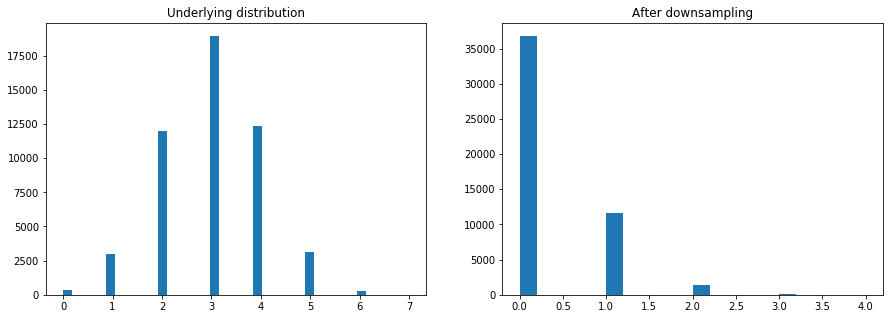

In [298]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1);
plt.title('Underlying distribution')
plt.hist(ground_truth_counts, bins=40);
plt.subplot(1, 2, 2);
plt.title('After downsampling')
plt.hist(observed, bins=20);

### Expectation step plots

Calculate the probabilities for the latent variable Z's.

In [299]:
z = 8
x = 0

In [300]:
vary_z_theoretical = []
vary_z_empirical = []
for z in range(1, 15):
    zs = list(range(20))
    px = (stats.norm.pdf(zs, mu, sigma) * stats.binom.pmf(x, zs, p)).sum()
    vary_z_theoretical.append(stats.norm.pdf(z, mu, sigma) * stats.binom.pmf(x, z, p) / px)
    vary_z_empirical.append((ground_truth_counts[observed == x] == z).mean())

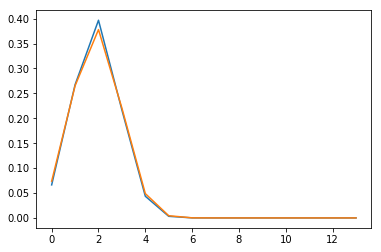

In [301]:
plt.plot(vary_z_theoretical)
plt.plot(vary_z_empirical)

In [302]:
z = 6
vary_x_theoretical = []
vary_x_empirical = []
for x in range(0, 4):
    zs = list(range(20))
    px = (stats.norm.pdf(zs, mu, sigma) * stats.binom.pmf(x, zs, p)).sum()
    vary_x_theoretical.append(stats.norm.pdf(z, mu, sigma) * stats.binom.pmf(x, z, p) / px)
    vary_x_empirical.append((ground_truth_counts[observed == x] == z).mean())

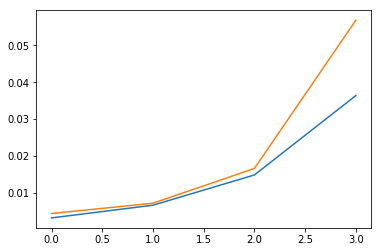

In [303]:
plt.plot(vary_x_theoretical)
plt.plot(vary_x_empirical)

### Expectation step: Computing probabilities for Z

In [304]:
def create_px_table(mu, sigma, p):
    return np.array([
        (stats.norm.pdf(np.arange(x, 20), mu, sigma) * stats.binom.pmf(x, np.arange(x, 20), p)).sum()
        for x in range(30)])

In [305]:
def create_pz_table(mu, sigma, p):
    """ Returns a matrix M x M where rows indicate X and columns indicate Z """
    
    px_table = create_px_table(mu, sigma, p)
    table = np.zeros(shape=(20, 20))
    for x in range(20):
        for z in range(x, 20):
            table[x, z] = stats.norm.pdf(z, mu, sigma) * stats.binom.pmf(x, z, p) / px_table[x]
    return table

### Maximization step: Fit a weighted Gaussian on the latent variables

In [306]:
def get_parameters(observed, prob_table):
    """ Get the parameters of the Gaussian and dropout """
    
    data = pd.DataFrame()
    data['observed'] = observed
    data = data.groupby('observed').size().reset_index(name='count')
    data['observed_weight'] = data['count'] / len(observed)
    data = data.merge(
        pd.concat(
            [pd.DataFrame(
                np.concatenate(
                    [np.ones(20-x).reshape(-1, 1)*x, 
                    np.arange(x, 20).reshape(-1,1),
                    prob_table[x, x:].reshape(-1, 1)], axis=1), 
                columns=['observed', 'latent', 'latent_weight']) for x in range(20)]),
        on='observed', 
        how='left')
    data['point_weight'] = data['observed_weight'] * data['latent_weight']
    data['p_estimates'] = (data['observed'] / data['latent'] * data['point_weight']).fillna(0.0).replace(np.inf, 0.0)
    p_estimate =0.1#min(max(data['p_estimates'].sum(), 0.05), 0.15)
    stat_estimates = DescrStatsW(data['latent'], weights=data['point_weight'])
    return stat_estimates.mean, np.sqrt(stat_estimates.var), p_estimate

### Perform EM

In [307]:
# Initialize hyperparameters for EM
NUM_ITER = 300

In [309]:
# Initialize the parameters
p_hat = 0.1
mu_hat = 5
sigma_hat = 2

In [310]:
fitting_progress = []
for itr in range(NUM_ITER):
    
    fitting_progress.append((itr, mu_hat, sigma_hat, p_hat))
    
    # E step
    prob_table = create_pz_table(mu_hat, sigma_hat, p_hat)
    
    # M step
    mu_hat, sigma_hat, p_hat = get_parameters(observed, prob_table)

In [311]:
fitting_progress = pd.DataFrame(fitting_progress, columns=['iteration', 'mu_hat', 'sigma_hat', 'p_hat'])

In [312]:
fitting_progress.tail(5)

,iteration,mu_hat,sigma_hat,p_hat
295,295,2.975192,0.926825,0.1
296,296,2.975172,0.926633,0.1
297,297,2.975152,0.926442,0.1
298,298,2.975133,0.926253,0.1
299,299,2.975113,0.926065,0.1


Text(0.5,1,'variance')

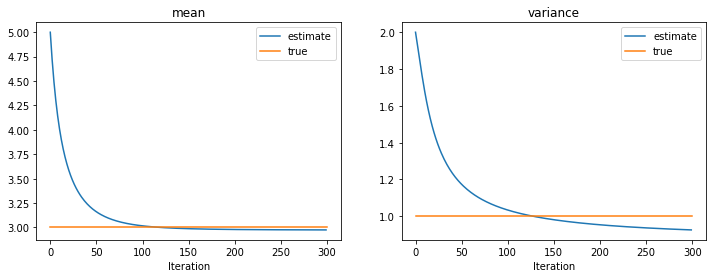

In [328]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(fitting_progress.iteration, fitting_progress.mu_hat)
plt.plot([0, NUM_ITER], [mu, mu])
plt.xlabel('Iteration'); plt.legend(['estimate', 'true']); plt.title('mean')
plt.subplot(1, 2, 2)
plt.plot(fitting_progress.iteration, fitting_progress.sigma_hat)
plt.plot([0, NUM_ITER], [sigma, sigma])
plt.xlabel('Iteration'); plt.legend(['estimate', 'true']); plt.title('variance')